In [1]:
import pystan as ps
import matplotlib.pyplot as plt
import pandas as pd

import os
cwd = os.getcwd()

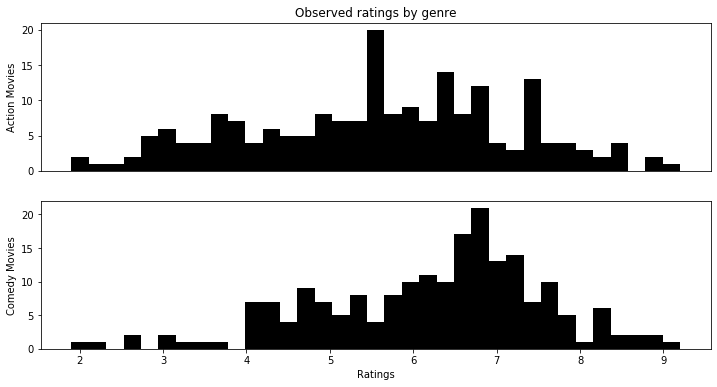

In [2]:
df = pd.read_csv(cwd + "/movies.csv")

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].hist(df[df["genre"] == "Action"]["rating"], bins = 35, color = "black")
ax[1].hist(df[df["genre"] == "Comedy"]["rating"], bins = 35, color = "black")

ax[0].title.set_text('Observed ratings by genre')
ax[0].set_ylabel("Action Movies")
ax[0].get_xaxis().set_visible(False)
ax[1].set_ylabel("Comedy Movies")
ax[1].set_xlabel("Ratings")
plt.show()

In [75]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)

    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

def posterior_density(ax, vec, width=.95):
    hdi = hpd(pd.np.asarray(vec), 1-width)
    ax.hist(vec, bins = 35, color = "black")
    ax.axvline(hdi[0], ls = "--", color = "grey")
    ax.axvline(hdi[1], ls = "--", color = "grey")
    ax.axvline(pd.np.mean(vec), color = "grey")
    ax.get_yaxis().set_visible(False)
    return ax

\begin{align}
rating &\sim student\_t(\nu, \mu_i, \sigma_i) \\
\mu_i &= \alpha_{group[i]} \\
\sigma_i &= \gamma_{group[i]} \\
\nu &\sim exponential(\frac{1}{29}) \\
\alpha &\sim normal(5.5, 2) \\
\sigma &\sim cauchy(0, 1) \\
\end{align}

In [6]:
df["genre"] = pd.Categorical(df["genre"])
data_dict = {
    "N": df.shape[0],
    "N_groups": df["genre"].nunique(),
    "outcome": df["rating"],
    "group_id": df["genre"].cat.codes+1
}
sm = ps.StanModel(file = cwd + "/BEST.stan")
fit = sm.sampling(data=data_dict, chains=4, n_jobs=4)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b733ec2da3dae24d6e2a9b35ecb56406 NOW.


Inference for Stan model: anon_model_b733ec2da3dae24d6e2a9b35ecb56406.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]     5.25  1.7e-3   0.11   5.03   5.18   5.26   5.33   5.48   4577    1.0
alpha[2]     6.22  1.4e-3    0.1   6.04   6.16   6.22   6.29   6.41   4682    1.0
gamma[1]     1.58  1.3e-3   0.08   1.43   1.53   1.58   1.64   1.75   4365    1.0
gamma[2]     1.32  1.1e-3   0.07   1.19   1.27   1.32   1.37   1.47   4156    1.0
nu           45.6     0.4  21.26  13.75  28.59  42.41  60.23  92.49   2819    1.0
mu_diff     -0.97  2.2e-3   0.15  -1.26  -1.07  -0.97  -0.87  -0.68   4331    1.0
sigma_diff   0.26  1.6e-3   0.11   0.05   0.19   0.26   0.33   0.47   4631    1.0
lp__       -496.9    0.04    1.6 -500.9 -497.7 -496.6 -495.7 -494.8   1831    1.0

Samples were drawn using NUTS at Sun Oct 20 01:28:46 2019.
For each para

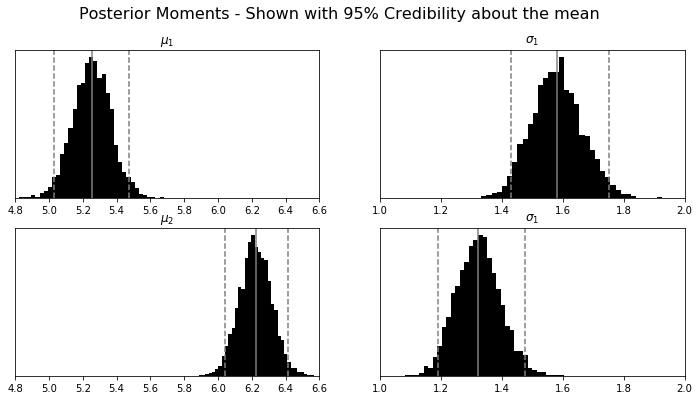

In [92]:
post = fit.extract(["alpha", "gamma"])

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

ax[0,0] = posterior_density(ax[0,0], [i for i,j in post['alpha']])
ax[0,0].title.set_text('$\mu_1$')
ax[0,0].set_xlim(left = 4.8, right = 6.6)
ax[1,0] = posterior_density(ax[1,0], [j for i,j in post['alpha']])
ax[1,0].title.set_text('$\mu_2$')
ax[1,0].set_xlim(left = 4.8, right = 6.6)

ax[0,1] = posterior_density(ax[0,1], [i for i,j in post['gamma']])
ax[0,1].title.set_text('$\sigma_1$')
ax[0,1].set_xlim(left = 1, right = 2)

ax[1,1] = posterior_density(ax[1,1], [j for i,j in post['gamma']])
ax[1,1].title.set_text('$\sigma_1$')
ax[1,1].set_xlim(left = 1, right = 2)

fig.suptitle('Posterior Moments - Shown with 95% Credibility about the mean', fontsize = 16)

plt.show()

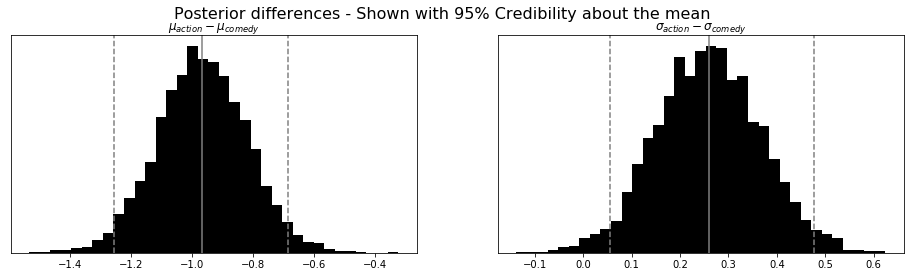

In [93]:
post = fit.extract(["mu_diff", "sigma_diff"])
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0] = posterior_density(ax[0], post["mu_diff"])
ax[0].title.set_text('$\mu_{action} - \mu_{comedy}$')

ax[1] = posterior_density(ax[1], post["sigma_diff"])
ax[1].title.set_text('$\sigma_{action} - \sigma_{comedy}$')
fig.suptitle('Posterior differences - Shown with 95% Credibility about the mean', fontsize = 16)

plt.show()

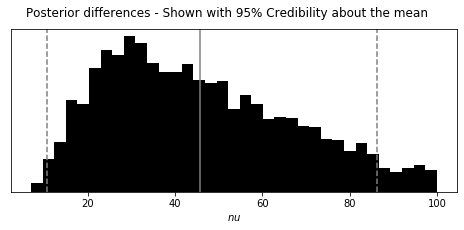

In [103]:
post = fit.extract("nu")
fig, ax = plt.subplots(1,1,figsize = (8, 3))
ax = posterior_density(ax, post["nu"])
ax.set_xlabel('$nu$')

fig.suptitle('Posterior differences - Shown with 95% Credibility about the mean')
plt.show()